In [1]:
import numpy as np
import seaborn as sns
import categorization as cat
import scipy.spatial.distance as dist
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt

2023-10-13 13:15:50.562388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 13:15:51.213291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-13 13:15:51.213353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-13 13:15:51.213359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
ecosetRepFile = "./representations/ecosetReps.npy"
ecosetReps = np.load(ecosetRepFile)
ecosetReps.shape  # Model, image, rep, rep, rep

(10, 800, 5, 5, 4096)

<AxesSubplot: ylabel='Density'>

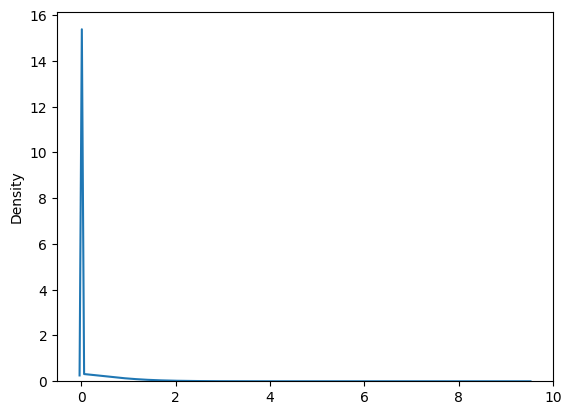

In [3]:
# Create KDE
sns.kdeplot(ecosetReps.reshape(10, -1)[0])

In [4]:
np.sort(ecosetReps.reshape(10, -1)[0])[::-1][:40]

array([9.489296 , 9.41915  , 9.401225 , 9.3423   , 9.20692  , 9.012685 ,
       8.980971 , 8.96843  , 8.9575815, 8.937443 , 8.936327 , 8.916255 ,
       8.855174 , 8.814647 , 8.7833185, 8.766338 , 8.727353 , 8.705983 ,
       8.7047825, 8.668722 , 8.656558 , 8.643278 , 8.620495 , 8.610479 ,
       8.601033 , 8.589037 , 8.585743 , 8.425695 , 8.355839 , 8.348903 ,
       8.328171 , 8.326214 , 8.304392 , 8.277966 , 8.255216 , 8.239977 ,
       8.199338 , 8.192115 , 8.180213 , 8.175612 ], dtype=float32)

In [5]:
np.median(ecosetReps.reshape(10, -1)[0])

0.0

In [6]:
# Preallocate array for similarity matrices
ecosetSimMat = np.zeros((10, 800, 800), dtype=np.float32)

# Loop through models
for i, modelReps in enumerate(ecosetReps):
    # Flatten model reps
    modelReps = modelReps.reshape(modelReps.shape[0], -1)

    # Calculate similarity matrix using default GCM
    ecosetSimMat[i] = cat.default_gcm_sim_mat(modelReps)

In [7]:
ecosetSimMat

array([[[1.        , 0.6017475 , 0.6230957 , ..., 0.54849964,
         0.5282454 , 0.52151877],
        [0.6017475 , 1.        , 0.5796788 , ..., 0.5245114 ,
         0.5049486 , 0.5019908 ],
        [0.6230957 , 0.5796788 , 1.        , ..., 0.53115517,
         0.5185499 , 0.5008697 ],
        ...,
        [0.54849964, 0.5245114 , 0.53115517, ..., 1.        ,
         0.6121496 , 0.6101775 ],
        [0.5282454 , 0.5049486 , 0.5185499 , ..., 0.6121496 ,
         1.        , 0.5865789 ],
        [0.52151877, 0.5019908 , 0.5008697 , ..., 0.6101775 ,
         0.5865789 , 1.        ]],

       [[1.        , 0.59875166, 0.6159241 , ..., 0.5502107 ,
         0.5353907 , 0.54832226],
        [0.59875166, 1.        , 0.57949007, ..., 0.526449  ,
         0.5100704 , 0.52772737],
        [0.6159241 , 0.57949007, 1.        , ..., 0.51978827,
         0.50850874, 0.5110535 ],
        ...,
        [0.5502107 , 0.526449  , 0.51978827, ..., 1.        ,
         0.5959505 , 0.60551155],
        [0.5

In [8]:
# Preallocate array for similarity matrices
ecosetTruncate1SimMat = np.zeros((10, 800, 800), dtype=np.float32)

# Loop through models
for i, modelReps in enumerate(ecosetReps):
    # Flatten model reps
    truncateReps = modelReps.reshape(modelReps.shape[0], -1)

    # Make activations lower than 1 equal to 0
    truncateReps[truncateReps < 1] = 0

    # Calculate similarity matrix using default GCM
    ecosetTruncate1SimMat[i] = cat.default_gcm_sim_mat(truncateReps)

In [9]:
np.prod(ecosetSimMat.shape)

6400000

In [10]:
np.corrcoef(ecosetSimMat.reshape(-1), ecosetTruncate1SimMat.reshape(-1))

array([[1.        , 0.95740528],
       [0.95740528, 1.        ]])

In [11]:
# Preallocate array for similarity matrices
ecosetTruncate2SimMat = np.zeros((10, 800, 800), dtype=np.float32)

# Loop through models
for i, modelReps in enumerate(ecosetReps):
    # Flatten model reps
    truncateReps = modelReps.reshape(modelReps.shape[0], -1)

    # Make activations lower than 2 equal to 0
    truncateReps[truncateReps < 2] = 0

    # Calculate similarity matrix using default GCM
    ecosetTruncate2SimMat[i] = cat.default_gcm_sim_mat(truncateReps)

In [12]:
np.corrcoef(ecosetSimMat.reshape(-1), ecosetTruncate2SimMat.reshape(-1))

array([[1.       , 0.6816256],
       [0.6816256, 1.       ]])

In [13]:
np.corrcoef(ecosetTruncate1SimMat.reshape(-1), ecosetTruncate2SimMat.reshape(-1))

array([[1.        , 0.84985129],
       [0.84985129, 1.        ]])

In [14]:
threshedSimMat = np.zeros((10, 800, 800), dtype=np.float32)

# Loop through models
for i, modelReps in enumerate(ecosetReps):
    # Flatten model reps
    modelReps = modelReps.reshape(modelReps.shape[0], -1)

    # Calculate similarity matrix using default GCM
    threshedSimMat[i] = dist.squareform(
        dist.pdist(modelReps, metric=cat.gcm_sim_thresholded)
    )

In [15]:
np.corrcoef(ecosetSimMat.reshape(-1), threshedSimMat.reshape(-1))

array([[1.        , 0.61121236],
       [0.61121236, 1.        ]])

In [16]:
threshed2SimMat = np.zeros((10, 800, 800), dtype=np.float32)

# Loop through models
for i, modelReps in enumerate(ecosetReps):
    # Flatten model reps
    modelReps = modelReps.reshape(modelReps.shape[0], -1)

    # Calculate similarity matrix using default GCM
    threshed2SimMat[i] = dist.squareform(
        dist.pdist(
            modelReps, metric=lambda x, y: cat.gcm_sim_thresholded(x, y, threshold=3)
        )
    )

In [17]:
np.corrcoef(ecosetSimMat.reshape(-1), threshed2SimMat.reshape(-1))

array([[1.        , 0.63538746],
       [0.63538746, 1.        ]])

In [18]:
np.corrcoef(threshedSimMat.reshape(-1), threshed2SimMat.reshape(-1))

array([[1.        , 0.75080792],
       [0.75080792, 1.        ]])

In [19]:
threshReps = ecosetReps[0] > 1
threshReps = threshReps.reshape(threshReps.shape[0], -1)
np.mean(np.sum(threshReps, axis=1))

1351.16375

<AxesSubplot: ylabel='Density'>

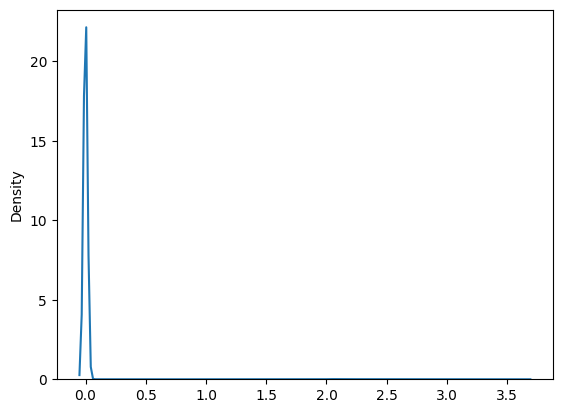

In [20]:
sns.kdeplot(ecosetReps[0].reshape(ecosetReps[0].shape[0], -1)[0])

<AxesSubplot: ylabel='Density'>

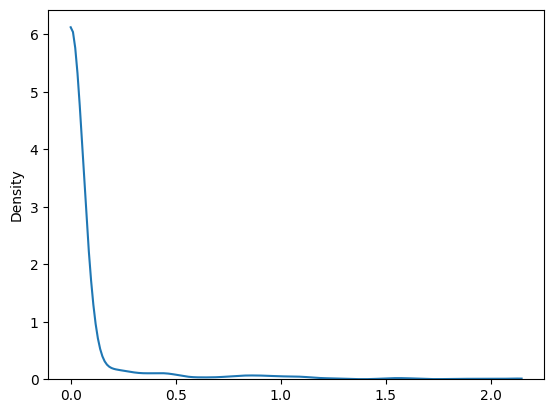

In [21]:
sns.kdeplot(
    np.concatenate([np.zeros(1024 - 128), np.random.gamma(1, 0.5, size=128)]), cut=0
)

[[ 0.          0.         14.00000001 14.00000001 22.09926241 22.09926241
  22.27159533 22.27159533]
 [ 0.          0.         14.00000001 14.00000001 22.09926241 22.09926241
  22.27159533 22.27159533]
 [14.00000001 14.00000001  0.          0.         22.28486425 22.28486425
  22.60494354 22.60494354]
 [14.00000001 14.00000001  0.          0.         22.28486425 22.28486425
  22.60494354 22.60494354]
 [22.09926241 22.09926241 22.28486425 22.28486425  0.          0.
  14.00000002 14.00000002]
 [22.09926241 22.09926241 22.28486425 22.28486425  0.          0.
  14.00000002 14.00000002]
 [22.27159533 22.27159533 22.60494354 22.60494354 14.00000002 14.00000002
   0.          0.        ]
 [22.27159533 22.27159533 22.60494354 22.60494354 14.00000002 14.00000002
   0.          0.        ]]


/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


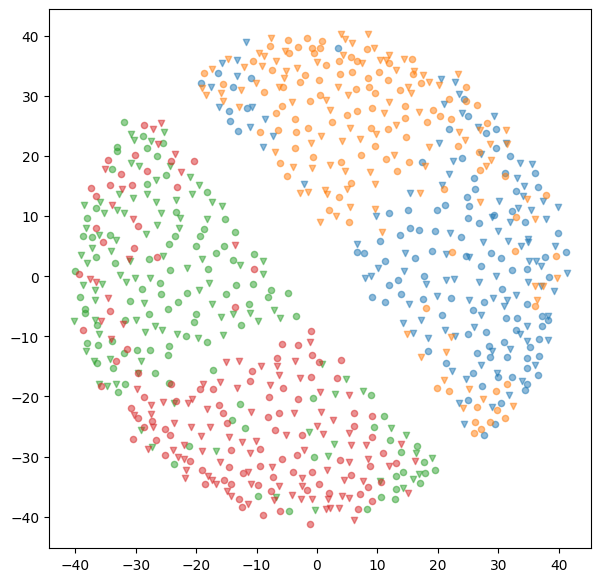

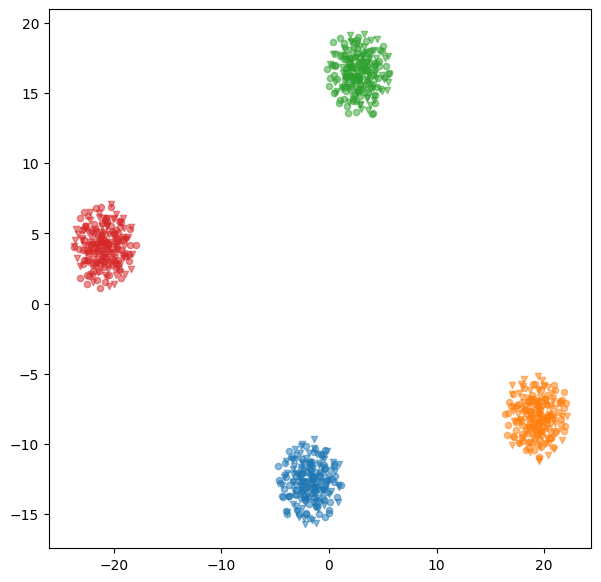

In [22]:
subExemplars, subCentroids = cat.make_categories(
    catCov=1, super_rad=10, basic_rad=7, sub_rad=0, nFeatures=1024, nImages=100
)

# Calculate similarity matrix
subSimMat = dist.squareform(dist.pdist(subExemplars, metric="euclidean"))

# Calculate similarity matrix of centroids
subCentroidSimMat = dist.squareform(dist.pdist(subCentroids, metric="euclidean"))
print(subCentroidSimMat)

# Do MDS
tmp = MDS(
    n_components=2,
    dissimilarity="precomputed",
)
subMDS = tmp.fit_transform(subSimMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
colors = sns.color_palette(n_colors=4)
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

# Do tsne
tmp = TSNE(n_components=2, metric="precomputed", init="random")
subTSNE = tmp.fit_transform(subSimMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

[[ 0.         25.95409615 26.88983712 ... 29.85300508 28.92877114
  28.28864764]
 [25.95409615  0.         26.27693057 ... 28.64186417 27.66545915
  28.11803198]
 [26.88983712 26.27693057  0.         ... 30.35709443 28.9663088
  29.00385418]
 ...
 [29.85300508 28.64186417 30.35709443 ...  0.         27.28063734
  27.55804729]
 [28.92877114 27.66545915 28.9663088  ... 27.28063734  0.
  26.25425795]
 [28.28864764 28.11803198 29.00385418 ... 27.55804729 26.25425795
   0.        ]]


/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


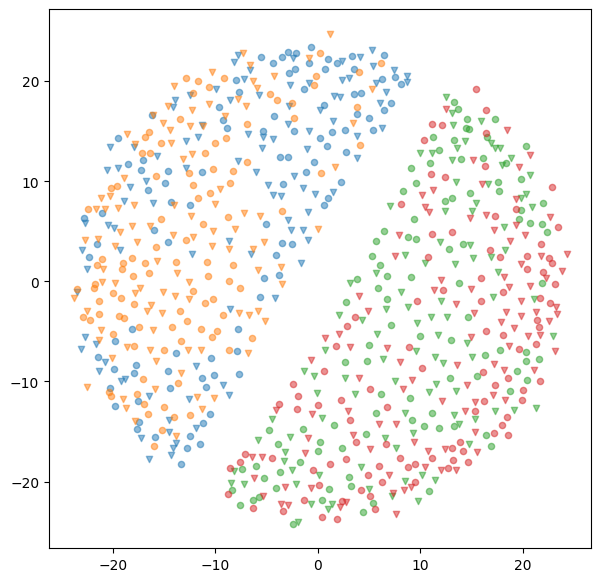

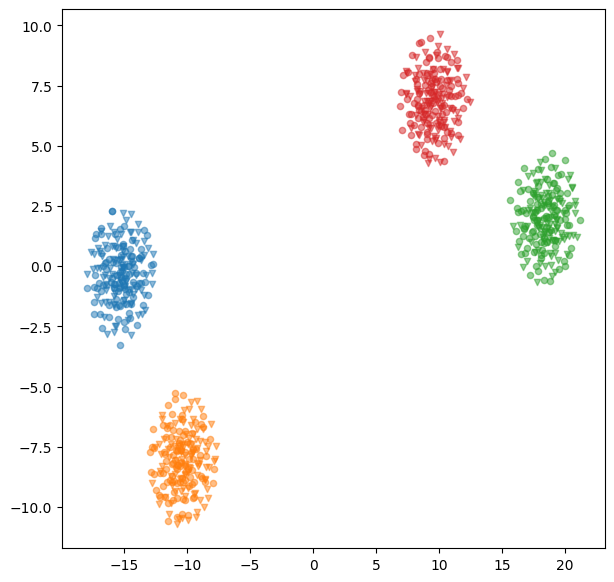

In [23]:
subExemplarsRelu = subExemplars.copy()
subExemplarsRelu[subExemplarsRelu < 0] = 0

# Calculate similarity matrix
subSimMatRelu = dist.squareform(dist.pdist(subExemplarsRelu, metric="euclidean"))
print(subSimMatRelu)

# Do MDS
tmp = MDS(
    n_components=2,
    dissimilarity="precomputed",
)
subMDSRelu = tmp.fit_transform(subSimMatRelu)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
colors = sns.color_palette(n_colors=4)
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subMDSRelu[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subMDSRelu[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

# Do tsne
tmp = TSNE(n_components=2, metric="precomputed", init="random")
subTSNERelu = tmp.fit_transform(subSimMatRelu)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subTSNERelu[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subTSNERelu[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

<AxesSubplot: ylabel='Density'>

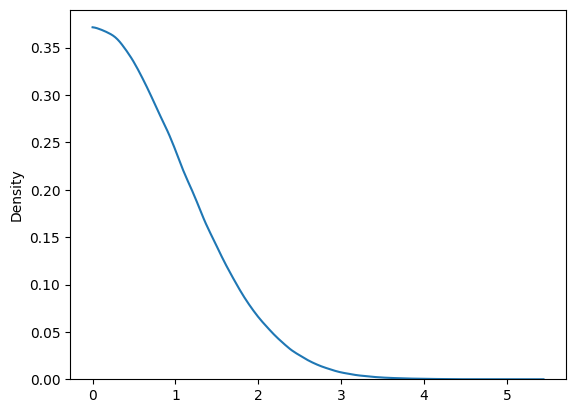

In [24]:
# Draw KDE of exemplar activations
sns.kdeplot(subExemplars.reshape(-1), clip=(0, None))

/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


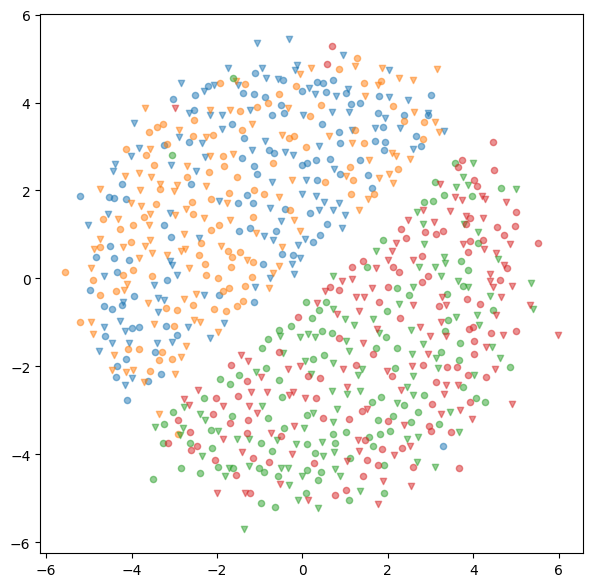

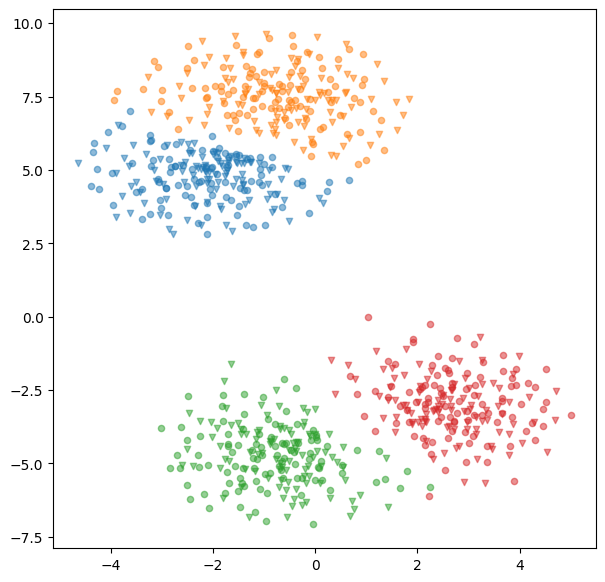

In [25]:
# Transform exemplars to be more gamma-like
subExemplarsGamma = subExemplars.copy()
subExemplarsGamma[subExemplarsGamma < 0] = 0
subExemplarsGamma = subExemplarsGamma**2 / 10

# Calculate similarity matrix
subSimMatGamma = dist.squareform(dist.pdist(subExemplarsGamma, metric="euclidean"))

# Do MDS
tmp = MDS(
    n_components=2,
    dissimilarity="precomputed",
)
subMDSGamma = tmp.fit_transform(subSimMatGamma)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
colors = sns.color_palette(n_colors=4)

for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subMDSGamma[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subMDSGamma[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

# Do tsne
tmp = TSNE(n_components=2, metric="precomputed", init="random")
subTSNEGamma = tmp.fit_transform(subSimMatGamma)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subTSNEGamma[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subTSNEGamma[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

<AxesSubplot: ylabel='Density'>

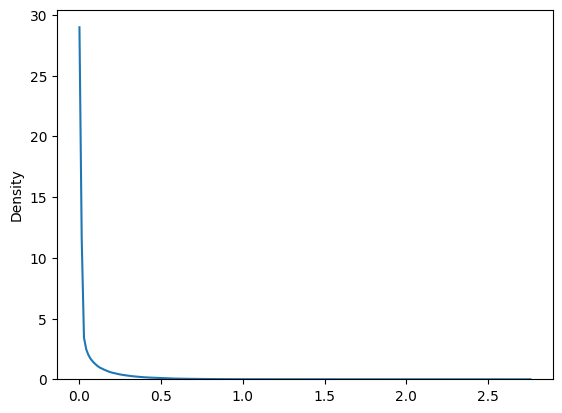

In [26]:
# Draw KDE of exemplar activations
sns.kdeplot(subExemplarsGamma.reshape(-1), clip=(0, None))